In [1]:
import os 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu
from tensorflow.keras.optimizers import Adam

def case_preprocessing():
    dataset = list()
    only_train_dataset = list()
    df = pd.DataFrame()
    train_df = pd.DataFrame()   # 새로운 Col 만들기 
    dir_path = 'C:\\Users\\gusrl\\opendrift\\drift_trajection'
    pastDir_path = 'C:\\Users\\gusrl\\opendrift\\drift_trajection\\Past_data'
    
    # hour, wind(바람의 x축,y축 방향 각각 제곱합의 루트), water(해류의 x축,y축 방향 각각 제곱합의 루트)
    for k in range(1,16):
        only_train_dataset.append(pd.read_csv(os.path.join(pastDir_path ,(str(k)+'.csv'))))
                                  
    # 2016 (case 7)
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_003.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_005.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_010.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_011.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_015.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_016.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_040.csv')))

    # 2018(case 12)
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_005.csv')))
    # dataset_list.append(pd.read_csv(os.path.join(dir_path,'2018_case_008.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_017.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_027.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_032.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_034.csv')))
    # dataset_list.append(pd.read_csv(os.path.join(dir_path,'2018_case_045.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_047.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_082.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_083.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_090.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_095.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_097.csv')))

    # 2019(case 4)
    dataset.append(pd.read_csv(os.path.join(dir_path,'2019_case_000.csv')))
#     dataset.append(pd.read_csv(os.path.join(dir_path,'2019_case_001.csv'))) 
    dataset.append(pd.read_csv(os.path.join(dir_path,'2019_case_005.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2019_case_006.csv'))) 
    dataset.append(pd.read_csv(os.path.join(dir_path,'2019_case_007.csv')))  
    
    # 과거데이터 전처리 
    for i in range(len(only_train_dataset)):
        # 시간처리를 위해 time의 object type -> datetime64로 변경
        only_train_dataset[i]['time'] = pd.to_datetime(only_train_dataset[i]['time'],format = '%Y-%m-%d %H:%M', errors = 'raise')
        # hour열 생성
        only_train_dataset[i]['hour'] = only_train_dataset[i]['time'].dt.hour
        # wind 열 생성
        only_train_dataset[i]['wind'] = (only_train_dataset[i]['wind_x']**2 + only_train_dataset[i]['wind_y']**2)**(1/2)
        # water열 생성
        only_train_dataset[i]['water'] = (only_train_dataset[i]['water_velocity_x']**2 + only_train_dataset[i]['water_velocity_y']**2)**(1/2)
        # diff_lon열 생성
        only_train_dataset[i]['diff_lon'] = only_train_dataset[i]['obs_x1_lon'].diff() 
        only_train_dataset[i]['diff_lon'][0] = 0
        # diff_lat열 생성
        only_train_dataset[i]['diff_lat'] = only_train_dataset[i]['obs_x1_lat'].diff()
        only_train_dataset[i]['diff_lat'][0] = 0
        # diff열 생성
        only_train_dataset[i]['diff'] = (only_train_dataset[i]['diff_lon']**2 + only_train_dataset[i]['diff_lat']**2)**(1/2)
        # Null 값 제외
        
        only_train_dataset[i] = only_train_dataset[i].dropna()
        only_train_dataset[i] = only_train_dataset[i].reset_index(drop = True)
        
        
        # 초기좌표 (해역 나누기)
        only_train_dataset[i]['start_lon'] = only_train_dataset[i]['obs_x1_lon'][0]
        only_train_dataset[i]['start_lat'] = only_train_dataset[i]['obs_x1_lat'][0]
        
        # Smoothing (wind_x_ma, wind_y_ma, water_velocity_x_ma, water_velocity_y_ma 인자 추가) 
        only_train_dataset[i]['wind_x_ma'] = 0
        only_train_dataset[i]['wind_y_ma'] = 0
        only_train_dataset[i]['water_velocity_x_ma'] = 0
        only_train_dataset[i]['water_velocity_y_ma'] = 0 
        for j in range(1,len(only_train_dataset[i])-1):
            only_train_dataset[i]['wind_x_ma'][j] = (only_train_dataset[i]['wind_x'][j-1] + only_train_dataset[i]['wind_x'][j] + only_train_dataset[i]['wind_x'][j+1])/3
            only_train_dataset[i]['wind_y_ma'][j] = (only_train_dataset[i]['wind_y'][j-1] + only_train_dataset[i]['wind_y'][j] + only_train_dataset[i]['wind_y'][j+1])/3
            only_train_dataset[i]['water_velocity_x_ma'][j] = (only_train_dataset[i]['water_velocity_x'][j-1] + only_train_dataset[i]['water_velocity_x'][j] + only_train_dataset[i]['water_velocity_x'][j+1])/3
            only_train_dataset[i]['water_velocity_y_ma'][j] = (only_train_dataset[i]['water_velocity_y'][j-1] + only_train_dataset[i]['water_velocity_y'][j] + only_train_dataset[i]['water_velocity_y'][j+1])/3    
        df = only_train_dataset[i]
        indices = df.query('wind_x < -90 or wind_y < -90 or water_velocity_x < -90 or water_velocity_y < -90').index
        df.drop(indices, inplace=True)
        df.reset_index(drop = True, inplace=True)
        only_train_dataset[i] = df 
        
     # 기상청 데이터 전처리 
    for i in range(len(dataset)):
        # 시간처리를 위해 time의 object type -> datetime64로 변경
        dataset[i]['time'] = pd.to_datetime(dataset[i]['time'],format = '%Y-%m-%d %H:%M', errors = 'raise')
        # hour열 생성
        dataset[i]['hour'] = dataset[i]['time'].dt.hour
        # wind 열 생성
        dataset[i]['wind'] = (dataset[i]['wind_x']**2 + dataset[i]['wind_y']**2)**(1/2)
        # water열 생성
        dataset[i]['water'] = (dataset[i]['water_velocity_x']**2 + dataset[i]['water_velocity_y']**2)**(1/2)
        # diff_lon열 생성
        dataset[i]['diff_lon'] = dataset[i]['obs_x1_lon'].diff() 
        dataset[i]['diff_lon'][0] = 0
        # diff_lat열 생성
        dataset[i]['diff_lat'] = dataset[i]['obs_x1_lat'].diff()
        dataset[i]['diff_lat'][0] = 0
        # diff열 생성
        dataset[i]['diff'] = (dataset[i]['diff_lon']**2 + dataset[i]['diff_lat']**2)**(1/2)
        # Null 값 제외
        print('dd', dataset[i].dropna().sum())
        dataset[i] = dataset[i].dropna()
        dataset[i] = dataset[i].reset_index(drop = True)
        
        # 초기좌표 (해역 나누기)
        dataset[i]['start_lon'] = dataset[i]['obs_x1_lon'][0]
        dataset[i]['start_lat'] = dataset[i]['obs_x1_lat'][0]
        
        # Smoothing (wind_x_ma, wind_y_ma, water_velocity_x_ma, water_velocity_y_ma 인자 추가) 
        dataset[i]['wind_x_ma'] = 0
        dataset[i]['wind_y_ma'] = 0
        dataset[i]['water_velocity_x_ma'] = 0
        dataset[i]['water_velocity_y_ma'] = 0 
        for j in range(1,len(dataset[i])-1):
            dataset[i]['wind_x_ma'][j] = (dataset[i]['wind_x'][j-1] + dataset[i]['wind_x'][j] + dataset[i]['wind_x'][j+1])/3
            dataset[i]['wind_y_ma'][j] = (dataset[i]['wind_y'][j-1] + dataset[i]['wind_y'][j] + dataset[i]['wind_y'][j+1])/3
            dataset[i]['water_velocity_x_ma'][j] = (dataset[i]['water_velocity_x'][j-1] + dataset[i]['water_velocity_x'][j] + dataset[i]['water_velocity_x'][j+1])/3
            dataset[i]['water_velocity_y_ma'][j] = (dataset[i]['water_velocity_y'][j-1] + dataset[i]['water_velocity_y'][j] + dataset[i]['water_velocity_y'][j+1])/3
        
        # 삭제 전 원본 df
        df = pd.concat([df,dataset[i]],ignore_index = True)
        # 불필요열 삭제 
        pre_df = dataset[i].drop(columns = ['time','obs_x1_lon','obs_x1_lat','model_x2_lon','model_x2_lat'])  
        train_df = pd.concat([train_df, pre_df[1:-1]],ignore_index = True)
        
    df = df.reset_index(drop = True)
    train_df = train_df.reset_index(drop = True)
    return dataset, df, train_df, only_train_dataset

def drift_mae(y, predict_y):
    mae = mean_absolute_error(y, predict_y)
    return mae


def n2_mae(y, predict_y):
    n = y.shape[0]
    error_sum = 0
    
    for i in range(n):
        error_sum += abs((y[i][0] - predict_y[i][0])) + abs(( y[i][1] - predict_y[i][1]))
    
    mae = error_sum/(2*n)   
    
    return mae


def paper_mae(y, predict_y): # 논문  
    n = y.shape[0]
    error_sum = 0
    
    for i in range(n):
        error_sum += abs(y[i][0] - predict_y[i][0]) + abs(y[i][1] - predict_y[i][1])
    
    mae = error_sum/n    
    return mae

def NCLS_score(y, predict_y): # 1시간 
        # dl_i 구하기 
        dl_list, dl_sum, o_sum = list(), list(), 0
        n = y.shape[0]
        for i in range(1, n):
            # 위도 1도는 111.321, 경도 1도는 87.74km, 단위 km
            d_lon = y[i][0] - y[i-1][0]  
            d_lat = y[i][1] - y[i-1][1]
            # 거리 구하기
            point_distance = np.sqrt(np.power(d_lon,2) + np.power(d_lat,2))
            dl_list.append(point_distance)
            
        for i in range(len(dl_list)):
            temp = 0
            for j in range(i+1):
                temp += dl_list[j]
            dl_sum.append(temp)

        for i in range(len(dl_sum)):
            o_sum += dl_sum[i]
        
        # 예측모델의 d_i 구하기
        d_list = list()
        for i in range(1,n):
            # 위도 1도는 111.321 # 경도 1도는 55.802km
            d_lon = y[i][0] - predict_y[i][0]  
            d_lat = y[i][1] - predict_y[i][1]
            # 거리 구하기
            point_distance = np.sqrt(np.power(d_lon,2) + np.power(d_lat,2))
            d_list.append(point_distance)

        # s 구하기
        d_sum, s, ss_score = 0, 0, 0

        for i in range(len(d_list)):
            d_sum += d_list[i]

        s = d_sum/o_sum
        
        if s > 1:
                ss_score = 0
        else:
            ss_score = 1-s
        
        return ss_score

def drift_trajection_show(index, y_pred): 
    %matplotlib inline

    # 실제 위치
    lon = dataset[index]['obs_x1_lon']
    lon = np.array(lon)
    lat = dataset[index]['obs_x1_lat']
    lat = np.array(lat)
    
    # baseline
    baseline_lon = dataset[index]['model_x2_lon']
    baseline_lon = np.array(baseline_lon)
    baseline_lat = dataset[index]['model_x2_lat']
    baseline_lat = np.array(baseline_lat)

    # 예측값 
    first_lon = lon[0]
    first_lat = lat[0]
    lon_pred = np.zeros((y_pred.shape[0]+1,))
    lat_pred = np.zeros((y_pred.shape[0]+1,))
    lon_pred[0] = first_lon 
    lat_pred[0] = first_lat
    
    for i in range(1, lon_pred.shape[0]):
        lon_pred[i] = lon_pred[i-1] + y_pred[i-1][0]
        lat_pred[i] = lat_pred[i-1] + y_pred[i-1][1]
        
    return lon, lat, baseline_lon, baseline_lat, lon_pred, lat_pred

def std_scaler(train_X, test_X):
    from sklearn.preprocessing import StandardScaler
    std = StandardScaler()
    std.fit(train_X)
    train_X_scaled = std.transform(train_X)
    test_X_scaled = std.transform(test_X)
    return train_X_scaled, test_X_scaled

def MinMax_scaler(train_X, test_X):
    from sklearn.preprocessing import MinMaxScaler
    mms = MinMaxScaler()
    mms.fit(train_X)
    train_X_scaled = mms.transform(train_X)
    test_X_scaled = mms.transform(test_X)
    return train_X_scaled, test_X_scaled
    
def roburst_scaler(train_X, test_X):
    from sklearn.preprocessing import RobustScaler
    rbs = RobustScaler()
    train_X_scaled = rbs.fit_transform(train_X)
    test_X_scaled = rbs.transform(test_X)
    return train_X_scaled, test_X_scaled


def maxAbsScaler(train_X, test_X):
    from sklearn.preprocessing import MaxAbsScaler
    maxAbsScaler = MaxAbsScaler()
    train_X_scaled = maxAbsScaler.fit_transform(train_X)
    test_X_scaled = maxAbsScaler.transform(test_X)
    return train_X_scaled, test_X_scaled

def data_augmenatation(dataset):
    for case in range(len(dataset)):
        df = dataset[case]
        length = len(df)
        index = 1
        for i in range(length-1):
            lon = (dataset[case]['obs_x1_lon'][i] + dataset[case]['obs_x1_lon'][i+1])/2
            lat = (dataset[case]['obs_x1_lat'][i] + dataset[case]['obs_x1_lat'][i+1])/2
            wind_x_mean = (dataset[case]['wind_x'][i] + dataset[case]['wind_x'][i+1])/2
            wind_y_mean = (dataset[case]['wind_y'][i] + dataset[case]['wind_y'][i+1])/2
            water_velocity_y_mean = (dataset[case]['water_velocity_y'][i] + dataset[case]['water_velocity_y'][i+1])/2
            water_velocity_x_mean = (dataset[case]['water_velocity_x'][i] + dataset[case]['water_velocity_x'][i+1])/2
            
            new_row = {'obs_x1_lon':lon, 'obs_x1_lat':lat,'wind_x':wind_x_mean, 'wind_y':wind_y_mean, 'water_velocity_y':water_velocity_y_mean, 'water_velocity_x':water_velocity_x_mean}
            temp1 = df[df.index < index]
            temp2 = df[df.index >= index]
            df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
            df.reset_index(drop = True, inplace=True)
            index += 2
                # diff_lon열 생성
        df['diff_lon'] = df['obs_x1_lon'].diff() 
        df['diff_lon'][0] = 0
        # diff_lat열 생성
        df['diff_lat'] = df['obs_x1_lat'].diff()
        df['diff_lat'][0] = 0
        dataset[case] = df

In [2]:
dataset, concat_df, train_df, only_train_dataset = case_preprocessing()

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_dataset[i]['diff_lon'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_dataset[i]['diff_lat'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_dataset

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_dataset[i]['wind_x_ma'][j] = (only_train_dataset[i]['wind_x'][j-1] + only_train_dataset[i]['wind_x'][j] + only_train_dataset[i]['wind_x'][j+1])/3
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_dataset[i]['wind_y_ma'][j] = (only_train_dataset[i]['wind_y'][j-1] + only_train_dataset[i]['wind_y'][j] + only_train_dataset[i]['wind_y'][j+1])/3
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:93: SettingWithCopyWarn

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:120: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print('dd', dataset[i].dropna().sum())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['wind_x_ma'][j] = (dataset[i]['wind_x'][j-1] + dataset[i]['wind_x'][j] + dataset[i]['wind_x'][j+1])/3
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http

dd obs_x1_lon          9365.471710
obs_x1_lat          2625.377980
model_x2_lon        9397.252120
model_x2_lat        2619.735677
wind_y              -223.128525
wind_x              -169.814762
water_velocity_y       3.104966
water_velocity_x      -1.261281
hour                 828.000000
wind                 471.798834
water                  6.922849
diff_lon              -0.860890
diff_lat              -0.137430
diff                   1.260368
dtype: float64
dd obs_x1_lon          9385.393560
obs_x1_lat          2611.544350
model_x2_lon        9345.924320
model_x2_lat        2591.911581
wind_y                 7.113362
wind_x                 4.561414
water_velocity_y      -4.096806
water_velocity_x      -6.013417
hour                 828.000000
wind                 192.566420
water                 14.714293
diff_lon               0.689340
diff_lat               0.263490
diff                   0.975133
dtype: float64
dd obs_x1_lon          9402.538710
obs_x1_lat          2670.197370
m

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['diff_lon'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['diff_lat'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:120: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warn

dd obs_x1_lon          9071.168510
obs_x1_lat          2601.830450
model_x2_lon        9079.526264
model_x2_lat        2597.238981
wind_y               138.227941
wind_x              -204.628375
water_velocity_y       6.449386
water_velocity_x       0.258247
hour                 828.000000
wind                 442.663213
water                 28.358990
diff_lon              -0.242650
diff_lat               0.194170
diff                   1.394438
dtype: float64
dd obs_x1_lon          9074.055000
obs_x1_lat          2576.186010
model_x2_lon        9069.831516
model_x2_lat        2575.292864
wind_y              -332.601462
wind_x               -71.373088
water_velocity_y      -3.196079
water_velocity_x      -1.722534
hour                 828.000000
wind                 351.121120
water                 28.077790
diff_lon              -0.070600
diff_lat              -0.325300
diff                   1.116975
dtype: float64
dd obs_x1_lon          9029.231400
obs_x1_lat          2510.761820
m

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['wind_x_ma'][j] = (dataset[i]['wind_x'][j-1] + dataset[i]['wind_x'][j] + dataset[i]['wind_x'][j+1])/3
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['wind_y_ma'][j] = (dataset[i]['wind_y'][j-1] + dataset[i]['wind_y'][j] + dataset[i]['wind_y'][j+1])/3
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cave

In [3]:
# Linear model & 이전데이터 

MAE_list = list()
NCLS_list = list()

for i in range(len(dataset)):
    print( '--------------------- Model ', i,' ----------------------')
    # train dataset
    train_X = pd.DataFrame()
    train_y = np.array([[]])
    train = dataset[0:i] + dataset[i+1:len(dataset)]
    
    train_X = train[0][['wind_x', 'wind_y', 'water_velocity_x', 'water_velocity_y']]
    train_y = train[0][['diff_lon', 'diff_lat']]
    # 첫 행은 훈련에서 제외
    train_X = train_X[1:]
    train_y = train_y[1:].to_numpy()
    
    for j in range(1,len(train)):
        trina_xi = train[j][['wind_x', 'wind_y', 'water_velocity_x', 'water_velocity_y']] 
        trina_yi = train[j][['diff_lon', 'diff_lat']]
        trina_xi = trina_xi[1:]
        trina_yi = trina_yi[1:].to_numpy()
        
        train_X = pd.concat([train_X,trina_xi],ignore_index = True)
        train_y = np.concatenate((train_y,trina_yi), axis = 0)
    
    # 과거 데이터 훈련데이터에 추가
    for k in range(len(only_train_dataset)):
        trina_xi = only_train_dataset[k][['wind_x','wind_y', 'water_velocity_x','water_velocity_y']] 
        trina_yi = only_train_dataset[k][['diff_lon','diff_lat']]
        trina_xi = trina_xi[1:]
        trina_yi = trina_yi[1:].to_numpy()
        
        train_X = pd.concat([train_X,trina_xi],ignore_index = True)
        train_y = np.concatenate((train_y,trina_yi), axis = 0)
        
    # Test dataset
    train_y
    test = dataset[i]
    test_X = test[['wind_x', 'wind_y', 'water_velocity_x','water_velocity_y']]
    test_X = test_X[1:]
    test_y = test[['diff_lon','diff_lat']]
    test_y = test_y[1:].to_numpy()

    # 선형모델 생성
    linear = tf.keras.Sequential([
    Dense(units = 2, input_dim = 4)
    ])
    
    linear.summary()
    linear.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])
    linear.fit(train_X, train_y, epochs = 30, batch_size = 16)

    # Predict
    y_pred = linear.predict(test_X)

    # 실제 위치
    lon = dataset[i]['obs_x1_lon']
    lon = np.array(lon)
    lat = dataset[i]['obs_x1_lat']
    lat = np.array(lat)
    
    # 예측값 
    first_lon = lon[0]
    first_lat = lat[0]
    lon_pred = np.zeros((y_pred.shape[0]+1,))
    lat_pred = np.zeros((y_pred.shape[0]+1,))
    lon_pred[0] = first_lon 
    lat_pred[0] = first_lat
    
    for t in range(1, lon_pred.shape[0]):
        lon_pred[t] = lon_pred[t-1] + y_pred[t-1][0]
        lat_pred[t] = lat_pred[t-1] + y_pred[t-1][0]        
    
    # evaluation 
    y = np.concatenate((lon.reshape((lon.shape[0],1)), lat.reshape((lat.shape[0],1))),axis = 1)
    pred = np.concatenate((lon_pred.reshape((lon_pred.shape[0],1)), lat_pred.reshape((lat_pred.shape[0],1))),axis =1)
    
    #mae
    print('Model',str(i),' MAE : ', drift_mae(lat, lat_pred))
    MAE_list.append(drift_mae(lat, lat_pred))
    
    #NCLS
    print('Model',str(i),' NCLS : ', NCLS_score(y, pred))
    NCLS_list.append(NCLS_score(y, pred))

--------------------- Model  0  ----------------------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 10        
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
185/185 [==============================] - 1s 953us/step - loss: 5.8218 - mae: 1.4899
Epoch 2/30
185/185 [==============================] - 0s 888us/step - loss: 3.0978 - mae: 1.0768
Epoch 3/30
185/185 [==============================] - 0s 1ms/step - loss: 1.4867 - mae: 0.7486
Epoch 4/30
185/185 [==============================] - 0s 924us/step - loss: 0.6440 - mae: 0.4934
Epoch 5/30
185/185 [==============================] - 0s 984us/step - loss: 0.2466 - mae: 0.3066
Epoch 6/30
185/185 [==============================

185/185 [==============================] - 0s 852us/step - loss: 4.7372 - mae: 1.3449
Epoch 3/30
185/185 [==============================] - 0s 971us/step - loss: 2.3071 - mae: 0.8959
Epoch 4/30
185/185 [==============================] - 0s 968us/step - loss: 1.0521 - mae: 0.5981
Epoch 5/30
185/185 [==============================] - 0s 983us/step - loss: 0.4539 - mae: 0.3938
Epoch 6/30
185/185 [==============================] - 0s 946us/step - loss: 0.1950 - mae: 0.2590
Epoch 7/30
185/185 [==============================] - 0s 943us/step - loss: 0.0851 - mae: 0.1699
Epoch 8/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0399 - mae: 0.1156
Epoch 9/30
185/185 [==============================] - 0s 1000us/step - loss: 0.0205 - mae: 0.0834
Epoch 10/30
185/185 [==============================] - 0s 978us/step - loss: 0.0118 - mae: 0.0633
Epoch 11/30
185/185 [==============================] - 0s 883us/step - loss: 0.0077 - mae: 0.0511
Epoch 12/30
185/185 [===================

185/185 [==============================] - 0s 960us/step - loss: 0.0023 - mae: 0.0324
Epoch 11/30
185/185 [==============================] - 0s 893us/step - loss: 0.0014 - mae: 0.0250
Epoch 12/30
185/185 [==============================] - 0s 905us/step - loss: 8.3071e-04 - mae: 0.0195
Epoch 13/30
185/185 [==============================] - 0s 1ms/step - loss: 4.8446e-04 - mae: 0.0153
Epoch 14/30
185/185 [==============================] - 0s 994us/step - loss: 2.8351e-04 - mae: 0.0121
Epoch 15/30
185/185 [==============================] - 0s 944us/step - loss: 1.7279e-04 - mae: 0.0099
Epoch 16/30
185/185 [==============================] - 0s 987us/step - loss: 1.1692e-04 - mae: 0.0083
Epoch 17/30
185/185 [==============================] - 0s 971us/step - loss: 9.0437e-05 - mae: 0.0074
Epoch 18/30
185/185 [==============================] - 0s 893us/step - loss: 7.9022e-05 - mae: 0.0068
Epoch 19/30
185/185 [==============================] - 0s 935us/step - loss: 7.4439e-05 - mae: 0.0066
Ep

185/185 [==============================] - 0s 917us/step - loss: 4.0771 - mae: 1.6253
Epoch 4/30
185/185 [==============================] - 0s 924us/step - loss: 2.0721 - mae: 1.1506
Epoch 5/30
185/185 [==============================] - 0s 922us/step - loss: 1.0083 - mae: 0.7945
Epoch 6/30
185/185 [==============================] - 0s 965us/step - loss: 0.4710 - mae: 0.5359
Epoch 7/30
185/185 [==============================] - 0s 931us/step - loss: 0.2175 - mae: 0.3598
Epoch 8/30
185/185 [==============================] - 0s 934us/step - loss: 0.1055 - mae: 0.2466
Epoch 9/30
185/185 [==============================] - 0s 931us/step - loss: 0.0581 - mae: 0.1801
Epoch 10/30
185/185 [==============================] - 0s 937us/step - loss: 0.0373 - mae: 0.1424
Epoch 11/30
185/185 [==============================] - 0s 901us/step - loss: 0.0267 - mae: 0.1193
Epoch 12/30
185/185 [==============================] - 0s 922us/step - loss: 0.0198 - mae: 0.1018
Epoch 13/30
185/185 [=================

185/185 [==============================] - 0s 911us/step - loss: 0.0183 - mae: 0.1037
Epoch 12/30
185/185 [==============================] - 0s 914us/step - loss: 0.0125 - mae: 0.0856
Epoch 13/30
185/185 [==============================] - 0s 918us/step - loss: 0.0090 - mae: 0.0723
Epoch 14/30
185/185 [==============================] - 0s 998us/step - loss: 0.0066 - mae: 0.0615
Epoch 15/30
185/185 [==============================] - 0s 918us/step - loss: 0.0049 - mae: 0.0523
Epoch 16/30
185/185 [==============================] - 0s 914us/step - loss: 0.0035 - mae: 0.0440
Epoch 17/30
185/185 [==============================] - 0s 912us/step - loss: 0.0025 - mae: 0.0367
Epoch 18/30
185/185 [==============================] - 0s 931us/step - loss: 0.0017 - mae: 0.0304
Epoch 19/30
185/185 [==============================] - 0s 913us/step - loss: 0.0012 - mae: 0.0249
Epoch 20/30
185/185 [==============================] - 0s 946us/step - loss: 7.8151e-04 - mae: 0.0203
Epoch 21/30
185/185 [=======

185/185 [==============================] - 0s 943us/step - loss: 0.0025 - mae: 0.0396
Epoch 20/30
185/185 [==============================] - 0s 894us/step - loss: 0.0017 - mae: 0.0328
Epoch 21/30
185/185 [==============================] - 0s 894us/step - loss: 0.0012 - mae: 0.0267
Epoch 22/30
185/185 [==============================] - 0s 969us/step - loss: 7.5195e-04 - mae: 0.0216
Epoch 23/30
185/185 [==============================] - 0s 960us/step - loss: 4.7856e-04 - mae: 0.0172
Epoch 24/30
185/185 [==============================] - 0s 995us/step - loss: 3.0386e-04 - mae: 0.0137
Epoch 25/30
185/185 [==============================] - 0s 966us/step - loss: 1.9714e-04 - mae: 0.0111
Epoch 26/30
185/185 [==============================] - 0s 961us/step - loss: 1.3594e-04 - mae: 0.0091
Epoch 27/30
185/185 [==============================] - 0s 943us/step - loss: 1.0254e-04 - mae: 0.0079
Epoch 28/30
185/185 [==============================] - 0s 964us/step - loss: 8.5327e-05 - mae: 0.0071
Epoc

185/185 [==============================] - 0s 924us/step - loss: 1.1121e-04 - mae: 0.0081
Epoch 28/30
185/185 [==============================] - 0s 871us/step - loss: 9.1442e-05 - mae: 0.0073
Epoch 29/30
185/185 [==============================] - 0s 869us/step - loss: 8.0975e-05 - mae: 0.0069
Epoch 30/30
3/3 [==============================] - 0s 1ms/step
Model 12  MAE :  0.3624522669342181
Model 12  NCLS :  0.20500167185939477
--------------------- Model  13  ----------------------
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 2)                 10        
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
185/185 [==============================] - 0s 667us/step - loss: 12.6120 - mae: 2.9069


                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
185/185 [==============================] - 0s 710us/step - loss: 4.9856 - mae: 1.7161
Epoch 2/30
185/185 [==============================] - 0s 908us/step - loss: 2.1732 - mae: 1.0840
Epoch 3/30
185/185 [==============================] - 0s 1ms/step - loss: 0.8660 - mae: 0.6444
Epoch 4/30
185/185 [==============================] - 0s 1ms/step - loss: 0.3145 - mae: 0.3711
Epoch 5/30
185/185 [==============================] - 0s 1ms/step - loss: 0.1044 - mae: 0.2127
Epoch 6/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0335 - mae: 0.1243
Epoch 7/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0121 - mae: 0.0769
Epoch 8/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0058 - mae: 0.0538
Epoch 9/30
185/185 [======================

185/185 [==============================] - 0s 976us/step - loss: 0.1411 - mae: 0.2763
Epoch 8/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0697 - mae: 0.1944
Epoch 9/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0403 - mae: 0.1504
Epoch 10/30
185/185 [==============================] - 0s 995us/step - loss: 0.0270 - mae: 0.1252
Epoch 11/30
185/185 [==============================] - 0s 973us/step - loss: 0.0198 - mae: 0.1082
Epoch 12/30
185/185 [==============================] - 0s 995us/step - loss: 0.0150 - mae: 0.0949
Epoch 13/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0115 - mae: 0.0832
Epoch 14/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0087 - mae: 0.0723
Epoch 15/30
185/185 [==============================] - 0s 982us/step - loss: 0.0064 - mae: 0.0621
Epoch 16/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0046 - mae: 0.0527
Epoch 17/30
185/185 [=======================

185/185 [==============================] - 0s 1ms/step - loss: 0.0017 - mae: 0.0287
Epoch 17/30
185/185 [==============================] - 0s 1ms/step - loss: 0.0012 - mae: 0.0240
Epoch 18/30
185/185 [==============================] - 0s 1ms/step - loss: 8.7870e-04 - mae: 0.0201
Epoch 19/30
185/185 [==============================] - 0s 1ms/step - loss: 6.1500e-04 - mae: 0.0169
Epoch 20/30
185/185 [==============================] - 0s 1ms/step - loss: 4.2649e-04 - mae: 0.0143
Epoch 21/30
185/185 [==============================] - 0s 1ms/step - loss: 2.9506e-04 - mae: 0.0122
Epoch 22/30
185/185 [==============================] - 0s 1ms/step - loss: 2.0657e-04 - mae: 0.0105
Epoch 23/30
185/185 [==============================] - 0s 1ms/step - loss: 1.4913e-04 - mae: 0.0092
Epoch 24/30
185/185 [==============================] - 0s 1ms/step - loss: 1.1379e-04 - mae: 0.0082
Epoch 25/30
185/185 [==============================] - 0s 1ms/step - loss: 9.3104e-05 - mae: 0.0075
Epoch 26/30
185/185 

180/180 [==============================] - 0s 693us/step - loss: 7.1656e-05 - mae: 0.0064
Epoch 25/30
180/180 [==============================] - 0s 657us/step - loss: 7.1593e-05 - mae: 0.0064
Epoch 26/30
180/180 [==============================] - 0s 683us/step - loss: 7.1611e-05 - mae: 0.0064
Epoch 27/30
180/180 [==============================] - 0s 667us/step - loss: 7.1698e-05 - mae: 0.0064
Epoch 28/30
180/180 [==============================] - 0s 684us/step - loss: 7.1741e-05 - mae: 0.0064
Epoch 29/30
180/180 [==============================] - 0s 650us/step - loss: 7.1602e-05 - mae: 0.0064
Epoch 30/30
5/5 [==============================] - 0s 989us/step
Model 21  MAE :  0.687962818411061
Model 21  NCLS :  0.3336322659344205


In [4]:
linear_mae_sum = 0
linear_NCLS_sum = 0

for i in range(len(dataset)):
    print('---------------- ',i+1,'model ----------------')
    linear_mae_sum += MAE_list[i]
    linear_NCLS_sum += NCLS_list[i]
    print(i+1,'model의 MAE : ',MAE_list[i])
    print(i+1,'model의 NCLS : ',NCLS_list[i])
    print('---------------------------------------------')
    print(' ')

# 라이브러리 Mae    
print ('평균 Mae : ', linear_mae_sum/len(dataset) )
print ('평균 NCLS : ', linear_NCLS_sum/len(dataset) )

----------------  1 model ----------------
1 model의 MAE :  0.19623524719450114
1 model의 NCLS :  0.3169413211754857
---------------------------------------------
 
----------------  2 model ----------------
2 model의 MAE :  0.24076120130297085
2 model의 NCLS :  0.04941028744438447
---------------------------------------------
 
----------------  3 model ----------------
3 model의 MAE :  0.38952802311814216
3 model의 NCLS :  0.41826540420020386
---------------------------------------------
 
----------------  4 model ----------------
4 model의 MAE :  0.18929219841958675
4 model의 NCLS :  0.016514304974984406
---------------------------------------------
 
----------------  5 model ----------------
5 model의 MAE :  0.43231100972046577
5 model의 NCLS :  0.3044239181778652
---------------------------------------------
 
----------------  6 model ----------------
6 model의 MAE :  0.2835117966417985
6 model의 NCLS :  0.47233867781149963
---------------------------------------------
 
----------------  

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff_lon'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff_lat'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: Futur

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff_lon'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:306: SettingWithCopyWarning: 
A value is trying to b

C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

--------------------- Model  0  ----------------------
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 2)                 10        
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30


C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_7392\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

952/952 [==============================] - 1s 913us/step - loss: 0.1731 - mae: 0.2919
Epoch 2/30
952/952 [==============================] - 1s 688us/step - loss: 0.0052 - mae: 0.0409
Epoch 3/30
952/952 [==============================] - 1s 1ms/step - loss: 2.2867e-05 - mae: 0.0027
Epoch 4/30
952/952 [==============================] - 1s 705us/step - loss: 5.0520e-06 - mae: 0.0015
Epoch 5/30
952/952 [==============================] - 1s 670us/step - loss: 5.0621e-06 - mae: 0.0015
Epoch 6/30
952/952 [==============================] - 1s 848us/step - loss: 5.0802e-06 - mae: 0.0015
Epoch 7/30
952/952 [==============================] - 1s 699us/step - loss: 5.1267e-06 - mae: 0.0015
Epoch 8/30
952/952 [==============================] - 1s 709us/step - loss: 5.1818e-06 - mae: 0.0016
Epoch 9/30
952/952 [==============================] - 1s 713us/step - loss: 5.2731e-06 - mae: 0.0016
Epoch 10/30
952/952 [==============================] - 1s 665us/step - loss: 5.4347e-06 - mae: 0.0016
Epoch 11/3

917/917 [==============================] - 1s 790us/step - loss: 5.2772e-06 - mae: 0.0016
Epoch 9/30
917/917 [==============================] - 1s 761us/step - loss: 5.3460e-06 - mae: 0.0016
Epoch 10/30
917/917 [==============================] - 1s 1ms/step - loss: 5.4123e-06 - mae: 0.0016
Epoch 11/30
917/917 [==============================] - 1s 823us/step - loss: 5.5111e-06 - mae: 0.0016
Epoch 12/30
917/917 [==============================] - 1s 1ms/step - loss: 5.7114e-06 - mae: 0.0017
Epoch 13/30
917/917 [==============================] - 1s 2ms/step - loss: 5.8782e-06 - mae: 0.0017
Epoch 14/30
917/917 [==============================] - 1s 786us/step - loss: 5.8970e-06 - mae: 0.0017
Epoch 15/30
917/917 [==============================] - 1s 761us/step - loss: 6.1344e-06 - mae: 0.0017
Epoch 16/30
917/917 [==============================] - 1s 706us/step - loss: 6.0921e-06 - mae: 0.0017
Epoch 17/30
917/917 [==============================] - 1s 721us/step - loss: 6.1323e-06 - mae: 0.0017

882/882 [==============================] - 1s 714us/step - loss: 6.1184e-06 - mae: 0.0017
Epoch 15/30
882/882 [==============================] - 1s 767us/step - loss: 6.2487e-06 - mae: 0.0018
Epoch 16/30
882/882 [==============================] - 1s 1ms/step - loss: 6.3959e-06 - mae: 0.0018
Epoch 17/30
882/882 [==============================] - 1s 682us/step - loss: 6.2160e-06 - mae: 0.0018
Epoch 18/30
882/882 [==============================] - 1s 709us/step - loss: 6.2569e-06 - mae: 0.0018
Epoch 19/30
882/882 [==============================] - 1s 726us/step - loss: 6.3836e-06 - mae: 0.0018
Epoch 20/30
882/882 [==============================] - 1s 729us/step - loss: 6.2783e-06 - mae: 0.0018
Epoch 21/30
882/882 [==============================] - 1s 746us/step - loss: 6.2752e-06 - mae: 0.0018
Epoch 22/30
882/882 [==============================] - 1s 900us/step - loss: 6.2809e-06 - mae: 0.0018
Epoch 23/30
882/882 [==============================] - 1s 720us/step - loss: 6.3882e-06 - mae: 0

846/846 [==============================] - 1s 596us/step - loss: 6.4387e-06 - mae: 0.0018
Epoch 21/30
846/846 [==============================] - 1s 619us/step - loss: 6.4754e-06 - mae: 0.0018
Epoch 22/30
846/846 [==============================] - 1s 634us/step - loss: 6.2675e-06 - mae: 0.0018
Epoch 23/30
846/846 [==============================] - 1s 626us/step - loss: 6.3237e-06 - mae: 0.0018
Epoch 24/30
846/846 [==============================] - 1s 677us/step - loss: 6.2341e-06 - mae: 0.0018
Epoch 25/30
846/846 [==============================] - 1s 670us/step - loss: 6.3084e-06 - mae: 0.0018
Epoch 26/30
846/846 [==============================] - 1s 603us/step - loss: 6.3341e-06 - mae: 0.0018
Epoch 27/30
846/846 [==============================] - 1s 591us/step - loss: 6.2840e-06 - mae: 0.0018
Epoch 28/30
846/846 [==============================] - 0s 583us/step - loss: 6.3736e-06 - mae: 0.0018
Epoch 29/30
846/846 [==============================] - 1s 591us/step - loss: 6.3364e-06 - mae:

811/811 [==============================] - 1s 705us/step - loss: 6.4953e-06 - mae: 0.0018
Epoch 27/30
811/811 [==============================] - 1s 714us/step - loss: 6.5415e-06 - mae: 0.0018
Epoch 28/30
811/811 [==============================] - 1s 815us/step - loss: 6.6092e-06 - mae: 0.0018
Epoch 29/30
811/811 [==============================] - 1s 703us/step - loss: 6.5411e-06 - mae: 0.0018
Epoch 30/30
18/18 [==============================] - 0s 882us/step
Model 8  MAE :  0.10468822190956528
Model 8  NCLS :  0.7888004709947858
--------------------- Model  9  ----------------------
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 2)                 10        
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_____________________________________________________________

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 2)                 10        
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
757/757 [==============================] - 1s 600us/step - loss: 0.1645 - mae: 0.2635
Epoch 2/30
757/757 [==============================] - 0s 645us/step - loss: 0.0094 - mae: 0.0506
Epoch 3/30
757/757 [==============================] - 0s 592us/step - loss: 1.3785e-04 - mae: 0.0060
Epoch 4/30
757/757 [==============================] - 0s 589us/step - loss: 6.1057e-06 - mae: 0.0017
Epoch 5/30
757/757 [==============================] - 0s 586us/step - loss: 5.8919e-06 - mae: 0.0017
Epoch 6/30
757/757 [==============================] - 0s 592us/step - loss: 5.8985e-06 - mae: 0.0017
Epoch 7/30

722/722 [==============================] - 0s 583us/step - loss: 0.0279 - mae: 0.1080
Epoch 3/30
722/722 [==============================] - 0s 590us/step - loss: 0.0013 - mae: 0.0195
Epoch 4/30
722/722 [==============================] - 0s 581us/step - loss: 1.9414e-05 - mae: 0.0029
Epoch 5/30
722/722 [==============================] - 0s 587us/step - loss: 6.0833e-06 - mae: 0.0017
Epoch 6/30
722/722 [==============================] - 0s 584us/step - loss: 6.0861e-06 - mae: 0.0017
Epoch 7/30
722/722 [==============================] - 0s 594us/step - loss: 6.0989e-06 - mae: 0.0017
Epoch 8/30
722/722 [==============================] - 0s 597us/step - loss: 6.1300e-06 - mae: 0.0017
Epoch 9/30
722/722 [==============================] - 0s 584us/step - loss: 6.1807e-06 - mae: 0.0017
Epoch 10/30
722/722 [==============================] - 0s 577us/step - loss: 6.2011e-06 - mae: 0.0017
Epoch 11/30
722/722 [==============================] - 0s 582us/step - loss: 6.3034e-06 - mae: 0.0018
Epoch 1

687/687 [==============================] - 0s 696us/step - loss: 6.3562e-06 - mae: 0.0018
Epoch 9/30
687/687 [==============================] - 1s 749us/step - loss: 6.3785e-06 - mae: 0.0018
Epoch 10/30
687/687 [==============================] - 1s 743us/step - loss: 6.4159e-06 - mae: 0.0018
Epoch 11/30
687/687 [==============================] - 1s 757us/step - loss: 6.4319e-06 - mae: 0.0018
Epoch 12/30
687/687 [==============================] - 1s 786us/step - loss: 6.5367e-06 - mae: 0.0018
Epoch 13/30
687/687 [==============================] - 1s 729us/step - loss: 6.5818e-06 - mae: 0.0018
Epoch 14/30
687/687 [==============================] - 1s 753us/step - loss: 6.7331e-06 - mae: 0.0019
Epoch 15/30
687/687 [==============================] - 1s 733us/step - loss: 7.0487e-06 - mae: 0.0019
Epoch 16/30
687/687 [==============================] - 1s 742us/step - loss: 6.9924e-06 - mae: 0.0019
Epoch 17/30
687/687 [==============================] - 1s 741us/step - loss: 7.1724e-06 - mae: 

651/651 [==============================] - 0s 587us/step - loss: 6.6130e-06 - mae: 0.0018
Epoch 15/30
651/651 [==============================] - 0s 594us/step - loss: 6.6559e-06 - mae: 0.0018
Epoch 16/30
651/651 [==============================] - 0s 588us/step - loss: 6.7548e-06 - mae: 0.0019
Epoch 17/30
651/651 [==============================] - 0s 593us/step - loss: 6.8577e-06 - mae: 0.0019
Epoch 18/30
651/651 [==============================] - 0s 590us/step - loss: 6.9607e-06 - mae: 0.0019
Epoch 19/30
651/651 [==============================] - 0s 583us/step - loss: 7.0975e-06 - mae: 0.0019
Epoch 20/30
651/651 [==============================] - 0s 661us/step - loss: 7.2574e-06 - mae: 0.0020
Epoch 21/30
651/651 [==============================] - 0s 584us/step - loss: 7.4053e-06 - mae: 0.0020
Epoch 22/30
651/651 [==============================] - 0s 589us/step - loss: 7.2687e-06 - mae: 0.0020
Epoch 23/30
651/651 [==============================] - 1s 774us/step - loss: 7.4508e-06 - mae:

616/616 [==============================] - 0s 786us/step - loss: 7.5467e-06 - mae: 0.0020
Epoch 21/30
616/616 [==============================] - 0s 773us/step - loss: 7.6406e-06 - mae: 0.0020
Epoch 22/30
616/616 [==============================] - 0s 761us/step - loss: 7.7311e-06 - mae: 0.0020
Epoch 23/30
616/616 [==============================] - 0s 793us/step - loss: 7.9507e-06 - mae: 0.0021
Epoch 24/30
616/616 [==============================] - 0s 757us/step - loss: 7.6811e-06 - mae: 0.0020
Epoch 25/30
616/616 [==============================] - 0s 770us/step - loss: 7.9389e-06 - mae: 0.0021
Epoch 26/30
616/616 [==============================] - 0s 806us/step - loss: 7.8876e-06 - mae: 0.0021
Epoch 27/30
616/616 [==============================] - 0s 762us/step - loss: 7.8869e-06 - mae: 0.0020
Epoch 28/30
616/616 [==============================] - 0s 762us/step - loss: 7.7417e-06 - mae: 0.0020
Epoch 29/30
616/616 [==============================] - 0s 779us/step - loss: 7.9516e-06 - mae:

546/546 [==============================] - 0s 792us/step - loss: 8.3387e-06 - mae: 0.0021
Epoch 27/30
546/546 [==============================] - 0s 779us/step - loss: 8.6132e-06 - mae: 0.0022
Epoch 28/30
546/546 [==============================] - 0s 796us/step - loss: 8.3319e-06 - mae: 0.0021
Epoch 29/30
546/546 [==============================] - 0s 775us/step - loss: 8.6069e-06 - mae: 0.0022
Epoch 30/30
36/36 [==============================] - 0s 843us/step
Model 21  MAE :  0.2761902216686288
Model 21  NCLS :  0.6199313734463405


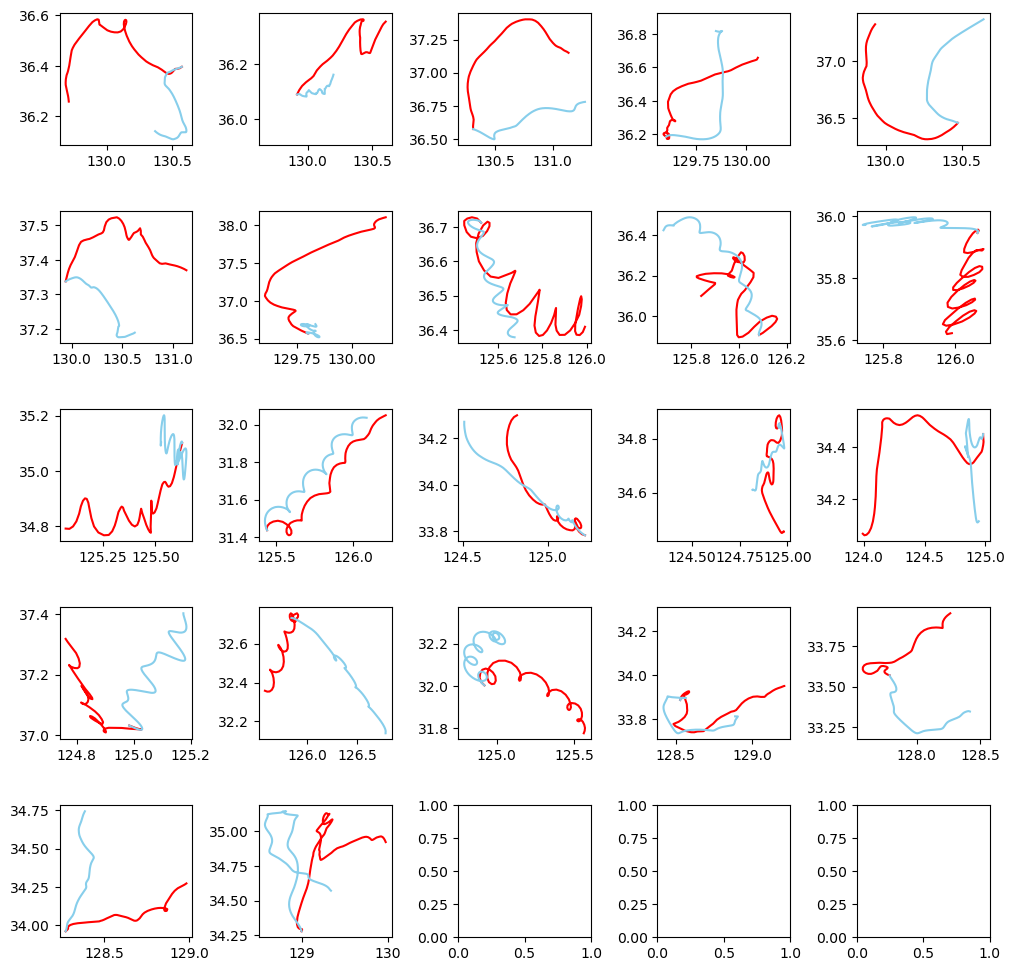

In [7]:
# Linear model & 데이터 추가

f, axes = plt.subplots(5, 5)
# 격자 크기 설정
f.set_size_inches((12, 12))
# 격자 여백 설정
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
MAE_list = list()
NCLS_list = list()
# 데이터 추가
data_augmenatation(dataset)
data_augmenatation(only_train_dataset)

for i in range(len(dataset)):
    print( '--------------------- Model ', i,' ----------------------')
    # train dataset
    train_X = pd.DataFrame()
    train_y = np.array([[]])
    train = dataset[0:i] + dataset[i+1:len(dataset)]
    
    train_X = train[0][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x']]
    train_y = train[0][['diff_lon', 'diff_lat']]
    # 첫 행은 훈련에서 제외
    train_X = train_X[1:]
    train_y = train_y[1:].to_numpy()
    
    for j in range(1,len(train)):
        trina_xi = train[j][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x']] 
        trina_yi = train[j][['diff_lon', 'diff_lat']]
        trina_xi = trina_xi[1:]
        trina_yi = trina_yi[1:].to_numpy()
        
        train_X = pd.concat([train_X,trina_xi],ignore_index = True)
        train_y = np.concatenate((train_y,trina_yi), axis = 0)
    
    # 과거 데이터 훈련데이터에 추가
    for k in range(len(only_train_dataset)):
        trina_xi = only_train_dataset[k][['wind_x','wind_y', 'water_velocity_x','water_velocity_y']] 
        trina_yi = only_train_dataset[k][['diff_lon','diff_lat']]
        trina_xi = trina_xi[1:]
        trina_yi = trina_yi[1:].to_numpy()
        
        train_X = pd.concat([train_X,trina_xi],ignore_index = True)
        train_y = np.concatenate((train_y,trina_yi), axis = 0)
       
    # Test dataset
    train_y
    test = dataset[i]
    test_X = test[['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x']]
    test_X = test_X[1:]
    test_y = test[['diff_lon', 'diff_lat']]
    test_y = test_y[1:].to_numpy()
    
    train_X, test_X = roburst_scaler(train_X, test_X)
    # 선형모델 생성
    linear = tf.keras.Sequential([
    Dense(units = 2, input_dim = 4)
    ])
    
    linear.summary()
    linear.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])
    linear.fit(train_X, train_y, epochs = 30, batch_size = 16)
    
    # model save
#     linear.save(str(i)+'linear_model.h5')

    # Predict
    y_pred = linear.predict(test_X)
    dataset[i] = dataset[i][::2]
    y_pred = y_pred[::2]
    test_X = test_X[::2]
    test_y = test_y[::2]
    
    # Plot
    lon, lat, baseline_lon, baseline_lat, lon_pred, lat_pred = drift_trajection_show(i,y_pred)
    row = i//5
    col = i%5
    axes[row][col].plot(lon, lat,'r-' ,baseline_lon, baseline_lat, 'g-', lon_pred, lat_pred, 'skyblue')   
    
    # evaluation 
    y = np.concatenate((lon.reshape((lon.shape[0],1)), lat.reshape((lat.shape[0],1))),axis = 1)
    pred = np.concatenate((lon_pred.reshape((lon_pred.shape[0],1)), lat_pred.reshape((lat_pred.shape[0],1))),axis =1)
    
    #mae
    
    print('Model',str(i),' MAE : ', drift_mae(y, pred))
    MAE_list.append(drift_mae(y, pred))
    
    #NCLS
    print('Model',str(i),' NCLS : ', NCLS_score(y, pred))
    NCLS_list.append(NCLS_score(y, pred))

plt.show()

In [8]:
linear_mae_sum = 0
linear_NCLS_sum = 0

for i in range(len(dataset)):
    print('---------------- ',i+1,'model ----------------')
    linear_mae_sum += MAE_list[i]
    linear_NCLS_sum += NCLS_list[i]
    print(i+1,'model의 MAE : ',MAE_list[i])
    print(i+1,'model의 NCLS : ',NCLS_list[i])
    print('---------------------------------------------')
    print(' ')

# 라이브러리 Mae    
print ('평균 Mae : ', linear_mae_sum/len(dataset) )
print ('평균 NCLS : ', linear_NCLS_sum/len(dataset) )

----------------  1 model ----------------
1 model의 MAE :  0.3332928145741607
1 model의 NCLS :  0.20048798367869536
---------------------------------------------
 
----------------  2 model ----------------
2 model의 MAE :  0.2270392187331991
2 model의 NCLS :  0.4270840678999318
---------------------------------------------
 
----------------  3 model ----------------
3 model의 MAE :  0.3086409508543685
3 model의 NCLS :  0.3593653021722083
---------------------------------------------
 
----------------  4 model ----------------
4 model의 MAE :  0.152950006681454
4 model의 NCLS :  0.26830014860343077
---------------------------------------------
 
----------------  5 model ----------------
5 model의 MAE :  0.26834973647943716
5 model의 NCLS :  0.40484076831494475
---------------------------------------------
 
----------------  6 model ----------------
6 model의 MAE :  0.1878654378377953
6 model의 NCLS :  0.5725956728344885
---------------------------------------------
 
----------------  7 model